In [1]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools

In [2]:
def compute_lomb_scargle(t, x, y, freq_count=1000):
    """
    Compute the Lomb-Scargle periodogram for the provided time series data.

    :param t: Time points array.
    :param x: X position data array.
    :param y: Y position data array.
    :param freq_count: Number of frequency bins to use for the periodogram.
    :return: Frequencies and the power spectrum (periodogram) of the signal.
    """
    # We will consider the system's kinetic energy time series as the signal.
    # Kinetic energy, KE = 0.5 * m * (v_x^2 + v_y^2), assuming mass (m) = 1 for simplicity.
    v_x = np.gradient(x, t)
    v_y = np.gradient(y, t)
    ke = 0.5 * (v_x**2 + v_y**2)
    
    # Normalize the signal
    ke_normalized = ke - np.mean(ke)

    # Define the frequency domain
    freqs = np.linspace(0.01, 10, freq_count)
    
    # Compute Lomb-Scargle periodogram
    power = lombscargle(t, ke_normalized, freqs, normalize=True)
    
    return freqs, power

In [3]:
def find_peak_frequency(freqs, power):
    """
    Find the peak frequency from the Lomb-Scargle periodogram.

    :param freqs: Frequencies array from the periodogram.
    :param power: Power spectrum from the periodogram.
    :return: Peak frequency.
    """
    # Find the index of the maximum power
    peak_index = np.argmax(power)
    # Return the corresponding frequency
    return freqs[peak_index]


In [4]:
def extract_features(x, y, v_x, v_y):
    """
    Extract features from the time series data for use in machine learning models.

    :param x: X position data array.
    :param y: Y position data array.
    :param v_x: X velocity data array.
    :param v_y: Y velocity data array.
    :return: Extracted features.
    """
    features = {
        'x_mean': np.mean(x),
        'y_mean': np.mean(y),
        'x_var': np.var(x),
        'y_var': np.var(y),
        'x_skew': skew(x),
        'y_skew': skew(y),
        'x_kurt': kurtosis(x),
        'y_kurt': kurtosis(y),
        'v_x_mean': np.mean(v_x),
        'v_y_mean': np.mean(v_y),
        'v_x_var': np.var(v_x),
        'v_y_var': np.var(v_y),
        'v_x_skew': skew(v_x),
        'v_y_skew': skew(v_y),
        'v_x_kurt': kurtosis(v_x),
        'v_y_kurt': kurtosis(v_y),
    }
    
    return features


In [5]:
def subsample_time_series(t, x, y, v_x, v_y, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: Time points array.
    :param x: X position data array.
    :param y: Y position data array.
    :param v_x: X velocity data array.
    :param v_y: Y velocity data array.
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return t[subsample_indices], x[subsample_indices], y[subsample_indices], v_x[subsample_indices], v_y[subsample_indices]

In [ ]:
# Number of samples to generate
num_samples = 100000
# Number of observations in each subsample
subsample_size = 30

# Prepare lists to hold the data
data_features = []
data_peak_freqs = []

# Generate the dataset
for i in range(num_samples):
    # Generate random initial conditions within a reasonable range
    np.random.seed(i)
    initial_conditions = np.random.rand(4)  
    # Simulate the system
    t_max = np.random.uniform(5, 20)  # Random end time for the observations
    t = np.linspace(0, t_max, 1000)  # Assume we have 1000 potential observations
    t, x, y, v_x, v_y = simulate_system(initial_conditions, t)
    
    # Subsample the time series data to simulate incomplete observations
    t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)
    
    # Compute the Lomb-Scargle periodogram on the subsampled data
    freqs, power = compute_lomb_scargle(t_sub, x_sub, y_sub)
    
    # Find the peak frequency
    peak_freq = find_peak_frequency(freqs, power)
    
    # Extract features from the subsampled time series data
    features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)
    
    # Store the features and peak frequency
    data_features.append(features)
    data_peak_freqs.append(peak_freq)

# Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['PeakFrequency'] = data_peak_freqs

# # Save the DataFrame to a CSV file
# features_df.to_csv('simulated_time_series_data.csv', index=False)


In [ ]:
features_df

In [ ]:
features_df['PeakFrequency'].describe()

In [ ]:
plt.hist(features_df['PeakFrequency'], bins=100)

In [6]:
def plot_solution(initial_conditions, t_max, num_points=100):
    """
    Plots the solution of the Newtonian potential system for given initial conditions.

    :param initial_conditions: List of initial conditions [x0, y0, v_x0, v_y0].
    :param t_max: Maximum time for the simulation.
    :param num_points: Number of points to generate in the time array.
    """
    # Generate time array
    t = np.linspace(0, t_max, num_points)

    # Use the simulate_system function to get the solution
    t, x, y, v_x, v_y = simulate_system(initial_conditions, t)

    # Plotting
    fig, axes = plt.subplots(5, 1, figsize=(5, 17))

    axes[0].plot(x, y, 'o', ms=1)
    axes[1].plot(t, x)
    axes[2].plot(t, y)
    axes[3].plot(t, v_x)
    axes[4].plot(t, v_y)

    axes[0].set_ylabel('y', fontsize=16)
    axes[0].set_xlabel('x', fontsize=16)
    axes[1].set_ylabel('x', fontsize=16)
    axes[2].set_ylabel('y', fontsize=16)
    axes[3].set_ylabel('v_x', fontsize=16)
    axes[4].set_ylabel('v_y', fontsize=16)

    for ax in axes[1:]:
        ax.set_xlabel('t', fontsize=16)

    plt.tight_layout()
    plt.show()


In [ ]:
initial_conditions = np.random.rand(4) 
t_max = 10 
plot_solution(initial_conditions, t_max)

In [ ]:
data = features_df.copy()

In [58]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [ ]:
data = remove_outliers(data, ['PeakFrequency'])

In [ ]:
data['PeakFrequency'].describe()

In [ ]:
data.dropna(inplace=True)

In [ ]:
# Split the data into features and target
X = data.drop('PeakFrequency', axis=1)
y = data['PeakFrequency']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")
# R2
r2 = rf_regressor.score(X_test, y_test)
print(f"R2 Score: {r2}")

In [ ]:
# Plot histogram of the test and of the predicted values
plt.hist(y_test, bins=100, label='test')    
plt.hist(y_pred, bins=100, label='predicted')

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [ ]:
# Set the initial conditions
initial_conditions = [1.0, 0.0, 0.0, 0.1]
t_max = 10  # value that we used for training
num_points = 100000  # same we used in training
subsample_size = 30  # same we used in training

# Generate the time series data
t, x, y, v_x, v_y = simulate_system(initial_conditions, np.linspace(0, t_max, num_points))

# Subsample the data (if your model was trained on subsampled data)
t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

# Extract features
features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

# Convert features to a format suitable for the model (e.g., DataFrame)
features_df = pd.DataFrame([features])

# Predict with the model
predicted_peak_frequency = rf_regressor.predict(features_df)

print(f"Predicted Peak Frequency: {predicted_peak_frequency[0]}")


In [8]:
def simulate_system(func, initial_conditions, t, params):
    """
    Generalized simulation function for different potentials.

    :param func: Function representing the equations of motion.
    :param initial_conditions: Initial conditions for the simulation.
    :param t: Array of time points for the simulation.
    :param params: Parameters required for the specific potential.
    :return: Simulated time series data.
    """
    solution = odeint(func, initial_conditions, t, args=params)
    return t, solution[:,0], solution[:,1], solution[:,2], solution[:,3]


In [9]:
def simulate_harmonic_oscillator(initial_conditions, t, omega, a):
    def equations_of_motion(xyv_xv_y, t, omega, a):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, a - omega**2 * x, a - omega**2 * y]
    
    return simulate_system(equations_of_motion, initial_conditions, t, (omega, a))


"""
EN CUATO AL POTENCIAL ARMONICO, COMO TE COMENTE EL PERIODO O FRECUENCIA NO DEPENDE DE LAS CONDICIONES INICIALES SINO DEL VALOR DE OMEGA
ESTE PUEDE VARIAR DESDE 0.1 HASTA 5 SABIENDO QUE CUANTO MAS CHICO ES OMEGA VAS A NECESITAR INTERVALOS DE OBSERVCION MAS GRANDES
AQUI EL PERIODO(no frecuencia) ESTA DADO POR  P=2*PI/OMEGA
"""

In [10]:
def simulate_modified_newtonian(initial_conditions, t, b, a):
    def equations_of_motion(xyv_xv_y, t, b, a):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, -x / (a * b**2 + x**2 + y**2)**(3/2), -y / (b**2 + x**2 + y**2)**(3/2)]

    return simulate_system(equations_of_motion, initial_conditions, t, (b, a))
"""
COMENTARIOS PARA EL PPOTENCIAL KEPLERIANO. CONDICIONES INICIALES X_0 O Y_0 SIEMPRE MAYOR QUE UNO ( UNO DE LOS DOS) EL OTRO PUEDE ARRANCAR DESDE CERO, 
PODES HACERLO CRECER MUCHO PERO CUANDO MAS GRANDE SEA LA ORBITA MAS LARGO VA A TENER QUE SER TU INTERVALO DE OBSERVACION >200 PARA X_0=1, Y_0=1) YO NO
LO HARIA MAS GRANDE QUE 1. 
SOBRE TODO PORQUE SI PONES VELOCIDADES MUY GRANDES LA ORBITA NO ES ESTABLE. EL MAXIMO ES 1 ENTONCES.

EN CUANTO A LAS VELOCIDADES INICIALES, LA SUMA DE AMBAS NO TIENE QUE SUPERAR 1.5, YO HARIA UNA HASTA 0.9 Y LA OTRA HASTA 0.6, Y ES SIMETRICO, 
ES DECIR QUE SI HACES V_X =0.9 Y LA OTRA 0.6, Y VICEVERZA EL PERIODO QUE SE OBTIENE S EL MISMO


"""


In [11]:
def simulate_custom_potential(initial_conditions, t, c, r0, alpha):
    def equations_of_motion(xyv_xv_y, t, c, r0, alpha):
        x, y, v_x, v_y = xyv_xv_y
        r = np.sqrt(x**2 + y**2)
        return [v_x, v_y, -(c * alpha * x) * (r0 / r)**(alpha - 1) * r0 / r**3,
                -(c * alpha * y) * (r0 / r)**(alpha - 1) * r0 / r**3]

    return simulate_system(equations_of_motion, initial_conditions, t, (c, r0, alpha))


In [12]:
def simulate_disk_galaxy(initial_conditions, t, vo, Rc, q):
    def equations_of_motion(rzv_rv_z, t, vo, Rc, q):
        r, z, v_r, v_z = rzv_rv_z
        return [v_r, v_z, (-vo**2 * r) / (Rc**2 + r**2 + (z/q)**2),
                (-vo**2 * z) / (q**2 * (Rc**2 + r**2 + (z/q)**2))]

    return simulate_system(equations_of_motion, initial_conditions, t, (vo, Rc, q))


In [13]:
def simulate_another_disk_galaxy(initial_conditions, t, vo, Rc, q):
    def equations_of_motion(rzv_rv_z, t, vo, Rc, q):
        r, z, v_r, v_z = rzv_rv_z
        return [v_r, v_z,
                -vo**2 * (-2 * r * np.sqrt(r**2 + z**2) - ((r * (r**2 - z**2)) / np.sqrt(r**2 + z**2)) + 2 * r) /
                (2 * (Rc**2 + (z/q)**2 - ((r**2 - z**2) * np.sqrt(r**2 + z**2)) + r**2)),
                -vo**2 * (2 * z * np.sqrt(r**2 + z**2) - ((z * (r**2 - z**2)) / np.sqrt(r**2 + z**2)) + 2 * z / q**2) /
                (2 * (Rc**2 + (z/q)**2 - ((r**2 - z**2) * np.sqrt(r**2 + z**2)) + r**2))]

    return simulate_system(equations_of_motion, initial_conditions, t, (vo, Rc, q))

In [14]:
def simulate_newtonian_potential(initial_conditions, t):
    def newtonian_equations_of_motion(xyv_xv_y, t):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, -x/(x**2 + y**2)**(3/2), -y/(x**2 + y**2)**(3/2)]

    return simulate_system(newtonian_equations_of_motion, initial_conditions, t)

In [15]:
def generate_sine_wave(t, A, w, psi):
    return A * np.sin(w * t + psi)

def generate_cosine_wave(t, A, w, psi):
    return A * np.cos(w * t + psi)

def extract_features_from_wave(x, t):
    """
    Extract features from the wave time series data for use in machine learning models.

    :param x: Wave data array (either sine or cosine wave).
    :param t: Time points array corresponding to the wave data.
    :return: Extracted features as a dictionary.
    """
    # Example feature extraction from the wave
    v_x = np.gradient(x, t)  # Derivative of x to simulate velocity-like feature

    features = {
        'x_mean': np.mean(x),
        'y_mean': 0,  # Placeholder as sine/cosine waves don't have y-component
        'x_var': np.var(x),
        'y_var': 0,  # Placeholder
        'x_skew': skew(x),
        'y_skew': 0,  # Placeholder
        'x_kurt': kurtosis(x),
        'y_kurt': 0,  # Placeholder
        'v_x_mean': np.mean(v_x),
        'v_y_mean': 0,  # Placeholder for velocity in y-direction
        'v_x_var': np.var(v_x),
        'v_y_var': 0,  # Placeholder
        'v_x_skew': skew(v_x),
        'v_y_skew': 0,  # Placeholder
        'v_x_kurt': kurtosis(v_x),
        'v_y_kurt': 0,  # Placeholder
        # Additional features can be added here if necessary
    }
    
    return features

In [41]:
# Define the possible values for each element
values = np.arange(0, 1.1, 0.1)  # Creates an array from 0 to 1 with a step of 0.1

# Generate all combinations of initial conditions
initial_conditions_combinations = list(itertools.product(values, repeat=4))

In [43]:
len(initial_conditions_combinations)

14641

In [17]:
# # Generate the dataset
# num_samples = 3000 
# subsample_size = 30

# data_features = []
# data_peak_freqs = []
# data_potential_types = []

# for potential_type, simulate_fn, num_params in [
#     ("Harmonic Oscillator", simulate_harmonic_oscillator, 2),
#     ("Modified Newtonian", simulate_modified_newtonian, 2),
#     ("Custom Potential", simulate_custom_potential, 3),
#     ("Disk Galaxy", simulate_disk_galaxy, 3),
#     ("Another Disk Galaxy", simulate_another_disk_galaxy, 3)
# ]:
#     for _ in range(num_samples):
#         initial_conditions = np.random.rand(4) * 2 - 1
#         params = np.random.rand(num_params)
#         t_max = np.random.uniform(5, 20)
#         t = np.linspace(0, t_max, 1000)

#         if num_params == 2:
#             t, x, y, v_x, v_y = simulate_fn(initial_conditions, t, params[0], params[1])
#         elif num_params == 3:
#             t, x, y, v_x, v_y = simulate_fn(initial_conditions, t, params[0], params[1], params[2])
#         # Add more cases if needed

#         t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)
#         freqs, power = compute_lomb_scargle(t_sub, x_sub, y_sub)
#         peak_freq = find_peak_frequency(freqs, power)
#         features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

#         data_features.append(features)
#         data_peak_freqs.append(peak_freq)
#         data_potential_types.append(potential_type)

# features_df = pd.DataFrame(data_features)
# features_df['PeakFrequency'] = data_peak_freqs
# features_df['PotentialType'] = data_potential_types


In [1]:
# Generate the dataset
subsample_size = 30

data_features = []
data_peak_freqs = []
data_potential_types = []

for potential_type, simulate_fn, num_params in [
    ("Harmonic Oscillator", simulate_harmonic_oscillator, 2),
    ("Modified Newtonian", simulate_modified_newtonian, 2),
    ("Custom Potential", simulate_custom_potential, 3),
    ("Disk Galaxy", simulate_disk_galaxy, 3),
    ("Another Disk Galaxy", simulate_another_disk_galaxy, 3),
    ("Newtonian Potential", simulate_newtonian_potential, 0) 
]:
    for initial_conditions in initial_conditions_combinations:
        params = np.random.rand(num_params)
        t_max = np.random.uniform(5, 20)
        t = np.linspace(0, t_max, 1000)

        if num_params == 2:
            t, x, y, v_x, v_y = simulate_fn(initial_conditions, t, params[0], params[1])
        elif num_params == 3:
            t, x, y, v_x, v_y = simulate_fn(initial_conditions, t, params[0], params[1], params[2])
        # Add more cases if needed

        t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)
        freqs, power = compute_lomb_scargle(t_sub, x_sub, y_sub)
        peak_freq = find_peak_frequency(freqs, power)
        features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

        data_features.append(features)
        data_peak_freqs.append(peak_freq)
        data_potential_types.append(potential_type)

features_df = pd.DataFrame(data_features)
features_df['PeakFrequency'] = data_peak_freqs
features_df['PotentialType'] = data_potential_types

NameError: name 'simulate_harmonic_oscillator' is not defined

In [60]:
num_samples = len(initial_conditions_combinations)

In [61]:
num_wave_samples = num_samples // 2  
for _ in range(num_wave_samples):
    t = np.linspace(0, 10, 1000)  

    # Sine wave parameters
    A, w, psi = 1.0, np.random.uniform(1.0, 5.0), np.random.uniform(0, 2 * np.pi)
    x = generate_sine_wave(t, A, w, psi)
    features = extract_features_from_wave(x, t)
    data_features.append(features)
    data_peak_freqs.append(w)  # Peak frequency is w
    data_potential_types.append('Sine Wave')

    # Cosine wave parameters
    A, w, psi = 1.0, np.random.uniform(1.0, 5.0), np.random.uniform(0, 2 * np.pi)
    x = generate_cosine_wave(t, A, w, psi)
    features = extract_features_from_wave(x, t)
    data_features.append(features)
    data_peak_freqs.append(w)  # Peak frequency is w
    data_potential_types.append('Cosine Wave')

# Compile all data into a DataFrame
features_df = pd.DataFrame(data_features)
features_df['PeakFrequency'] = data_peak_freqs
features_df['PotentialType'] = data_potential_types

In [2]:
# Assuming features_df is your DataFrame
potential_types = features_df['PotentialType'].unique()

plt.figure(figsize=(15, 10))
for i, potential_type in enumerate(potential_types):
    plt.subplot(len(potential_types), 1, i + 1)
    plt.hist(features_df[features_df['PotentialType'] == potential_type]['PeakFrequency'], bins=30, alpha=0.7)
    plt.title(f'Peak Frequency Distribution for {potential_type}')
    plt.xlabel('Peak Frequency')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

NameError: name 'features_df' is not defined

In [63]:
features_df['PotentialType'].unique()

array(['Harmonic Oscillator', 'Modified Newtonian', 'Custom Potential',
       'Disk Galaxy', 'Another Disk Galaxy', 'Newtonian Potential',
       'Sine Wave', 'Cosine Wave'], dtype=object)

In [64]:
features_df

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,PeakFrequency,PotentialType
0,0.565095,0.565095,0.296072,0.296072,0.446468,0.446468,-1.382054,-1.382054,0.043537,0.043537,0.187667,0.187667,-0.126070,-0.126070,-1.270119,-1.270119,1.710000,Harmonic Oscillator
1,0.340983,0.342442,0.067496,0.069564,0.224259,0.173282,-1.557914,-1.512754,0.005183,0.010708,0.061361,0.069293,-0.018721,0.026100,-1.535118,-1.563427,1.980000,Harmonic Oscillator
2,0.340983,0.343901,0.067496,0.081358,0.224259,0.078943,-1.557914,-1.428766,0.005183,0.016233,0.061361,0.087588,-0.018721,0.018486,-1.535118,-1.542510,1.970000,Harmonic Oscillator
3,0.340983,0.345360,0.067496,0.102877,0.224259,-0.004475,-1.557914,-1.364361,0.005183,0.021758,0.061361,0.116245,-0.018721,-0.019606,-1.535118,-1.521226,1.970000,Harmonic Oscillator
4,0.340983,0.346819,0.067496,0.134122,0.224259,-0.056957,-1.557914,-1.338216,0.005183,0.027283,0.061361,0.155265,-0.018721,-0.062021,-1.535118,-1.513019,1.970000,Harmonic Oscillator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102481,-0.029855,0.000000,0.493734,0.000000,0.076911,0.000000,-1.483344,0.000000,0.106645,0.000000,3.553250,0.000000,-0.090586,0.000000,-1.501660,0.000000,2.656122,Cosine Wave
102482,0.047778,0.000000,0.498311,0.000000,-0.098325,0.000000,-1.487078,0.000000,-0.113034,0.000000,5.897667,0.000000,0.056429,0.000000,-1.493546,0.000000,3.440879,Sine Wave
102483,-0.014685,0.000000,0.504185,0.000000,0.030419,0.000000,-1.510266,0.000000,0.025383,0.000000,5.048446,0.000000,-0.027639,0.000000,-1.493124,0.000000,3.192410,Cosine Wave
102484,-0.002955,0.000000,0.503430,0.000000,0.011327,0.000000,-1.507616,0.000000,-0.036856,0.000000,9.408352,0.000000,0.014625,0.000000,-1.493737,0.000000,4.354570,Sine Wave


In [65]:
features_df.isna().sum()

x_mean            2220
y_mean            2220
x_var             2220
y_var             2220
x_skew           19923
y_skew           19999
x_kurt           19923
y_kurt           19999
v_x_mean          2220
v_y_mean          2269
v_x_var           2220
v_y_var           2269
v_x_skew         19969
v_y_skew         19795
v_x_kurt         19969
v_y_kurt         19795
PeakFrequency        0
PotentialType        0
dtype: int64

In [66]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [67]:
features_df['PotentialType'].unique()

array(['Harmonic Oscillator', 'Modified Newtonian', 'Custom Potential',
       'Disk Galaxy', 'Another Disk Galaxy', 'Newtonian Potential',
       'Sine Wave', 'Cosine Wave'], dtype=object)

In [68]:
features_df.describe()

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,PeakFrequency
count,1.024860e+05,1.024860e+05,1.024860e+05,1.024860e+05,102486.000000,102486.000000,102486.000000,102486.000000,1.024860e+05,1.024860e+05,1.024860e+05,1.024860e+05,102486.000000,102486.000000,102486.000000,102486.000000,102486.000000
mean,2.406419e+277,1.914305e+288,inf,inf,-0.056466,-0.072606,-0.804668,-0.638222,1.281197e+277,8.264457e+276,inf,inf,0.117831,0.103700,-0.272722,-0.192400,1.554193
std,inf,inf,NaN,NaN,0.535135,0.523528,1.342402,1.338748,inf,inf,NaN,NaN,0.723888,0.661533,2.004460,1.721291,1.410235
min,-2.426173e+00,-2.021126e+00,0.000000e+00,0.000000e+00,-4.251817,-2.977344,-1.876533,-1.900532,-7.742675e+03,-7.743956e+03,0.000000e+00,0.000000e+00,-5.199469,-5.199469,-1.999655,-1.988625,0.010000
25%,3.960058e-02,2.712749e-02,1.783715e-01,5.276881e-02,-0.245211,-0.257238,-1.493718,-1.422030,-5.611018e-04,0.000000e+00,1.265934e-01,2.692360e-02,-0.147143,-0.117475,-1.434205,-1.134000,0.240000
50%,3.453596e-01,3.368875e-01,4.936840e-01,3.093676e-01,-0.020445,0.000000,-1.291433,-0.994782,4.651140e-02,2.770611e-02,3.439563e-01,2.046478e-01,0.000000,0.000000,-0.684301,-0.212692,1.466347
75%,2.239234e+00,2.357547e+00,3.365799e+00,3.621778e+00,0.008051,0.000000,0.000000,0.000000,3.759029e-01,3.733989e-01,7.022389e+00,5.700910e-01,0.135667,0.107622,0.000000,0.000000,2.110000
max,1.539899e+280,1.961894e+293,inf,inf,5.142213,5.199469,24.649280,25.034483,1.539939e+280,1.539911e+280,inf,inf,5.151124,5.096586,25.034483,25.034483,9.930000


In [69]:
# Drop outliers all the columns except PotentialType
features_df = remove_outliers(features_df, features_df.columns.drop('PotentialType'))

/opt/anaconda3/envs/pycaret3/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [70]:
features_df.describe()

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,PeakFrequency
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
features_df

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,PeakFrequency,PotentialType


In [72]:
len(initial_conditions_combinations)

14641

In [65]:
data = features_df.copy()
# %%
data = remove_outliers(data, ['PeakFrequency'])

# %%
data['PeakFrequency'].describe()

# %%
data.dropna(inplace=True)

# %%
# Split the data into features and target
X = data.drop('PeakFrequency', axis=1)[['x_mean', 'x_var', 'x_skew', 'x_kurt', 'v_x_mean', 'v_x_var', 'v_x_skew', 'v_x_kurt']]
y = data['PeakFrequency']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")
# R2
r2 = rf_regressor.score(X_test, y_test)
print(f"R2 Score: {r2}")

Mean Squared Error: 7.113251186654452e-05
Mean Absolute Percentage Error: 0.21099876544336227
R2 Score: 0.9999353611196422


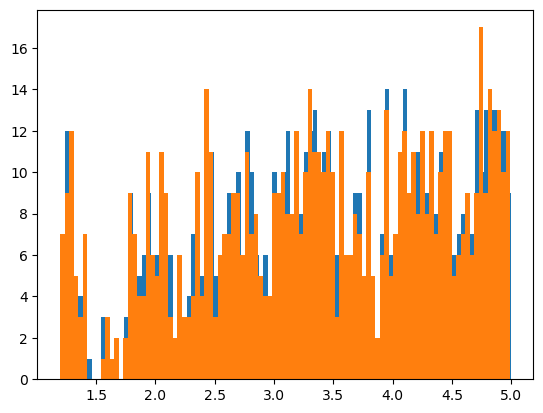

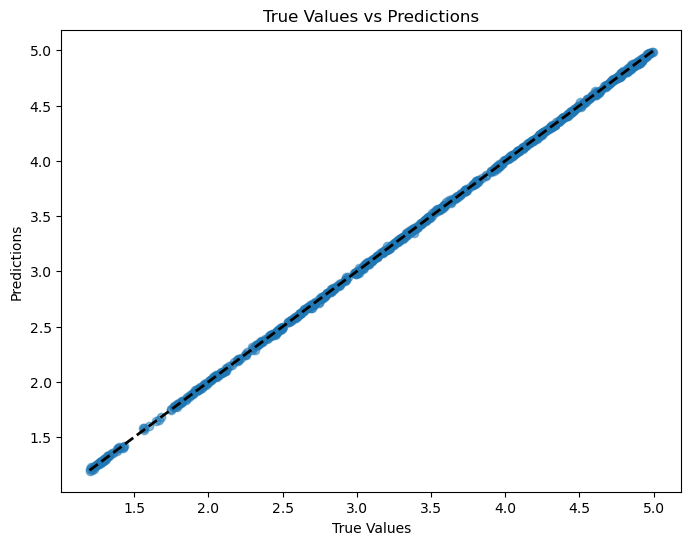

In [66]:
# %%
# Plot histogram of the test and of the predicted values
plt.hist(y_test, bins=100, label='test')    
plt.hist(y_pred, bins=100, label='predicted')

# %%
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [67]:
def simulate_system(initial_conditions, t):
    """
    Simulate the system of equations for a Newtonian potential and return the time series data.
    
    :param initial_conditions: List of initial conditions [x0, y0, v_x0, v_y0].
    :param t: Time points array for which to solve the equations of motion.
    :return: Tuple of time array and integrated values for x, y, v_x, and v_y.
    """
    def equations_of_motion(w, t):
        x, y, v_x, v_y = w
        r = (x**2 + y**2)**0.5
        return [v_x, v_y, -x/r**3, -y/r**3]

    # Integrate the equations of motion
    solution = odeint(equations_of_motion, initial_conditions, t)
    return t, solution[:, 0], solution[:, 1], solution[:, 2], solution[:, 3]

In [77]:
# %%
# Set the initial conditions
initial_conditions = [1.0, 0.0, 0.0, 0.1]
t_max = 10  # value that we used for training
num_points = 30  # same we used in training
subsample_size = 30  # same we used in training

# Generate the time series data
t, x, y, v_x, v_y = simulate_system(initial_conditions, np.linspace(0, t_max, num_points))

# Subsample the data
t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

# Extract features
features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

# Select only the features used in training
selected_features = ['x_mean', 'x_var', 'x_skew', 'x_kurt', 'v_x_mean', 'v_x_var', 'v_x_skew', 'v_x_kurt']
features_for_prediction = {feature: features[feature] for feature in selected_features}

# Create a DataFrame for prediction
features_df = pd.DataFrame([features_for_prediction])

# Predict with the model
predicted_peak_frequency = rf_regressor.predict(features_df)

print(f"Predicted Peak Frequency: {predicted_peak_frequency[0]}")


Predicted Peak Frequency: 1.5572841491652067


In [69]:
# Define initial conditions and time array
initial_conditions = [1.0, 0.0, 0.0, 0.1]
t_max = 10
t = np.linspace(0, t_max, 1000)

# Generate the time series data
t, x, y, v_x, v_y = simulate_system(initial_conditions, t)

In [70]:
# Compute the Lomb-Scargle periodogram
freqs, power = compute_lomb_scargle(t, x, y)

# Optionally, you can focus on a subset of frequencies for a clearer view
focus_freqs = freqs[:100]  # Adjust this as needed
focus_power = power[:100]

Frequency: 0.01, Power: 0.001026518018565994
Frequency: 0.02, Power: 0.0010266398092660543
Frequency: 0.03, Power: 0.001026854741996604
Frequency: 0.04, Power: 0.0010271808974196643
Frequency: 0.05, Power: 0.0010276439048766295
Frequency: 0.060000000000000005, Power: 0.0010282772581130754
Frequency: 0.06999999999999999, Power: 0.0010291227197489266
Frequency: 0.08, Power: 0.0010302308125322353
Frequency: 0.09, Power: 0.0010316613939559023
Frequency: 0.09999999999999999, Power: 0.0010334843086552924
Frequency: 0.11, Power: 0.0010357801099355178
Frequency: 0.12, Power: 0.0010386408375550654
Frequency: 0.13, Power: 0.0010421708332326264
Frequency: 0.14, Power: 0.001046487567923634
Frequency: 0.15000000000000002, Power: 0.0010517224453808318
Frequency: 0.16, Power: 0.001058021534502927
Frequency: 0.17, Power: 0.0010655461681505392
Frequency: 0.18000000000000002, Power: 0.0010744733282080992
Frequency: 0.19, Power: 0.0010849957156028958
Frequency: 0.2, Power: 0.0010973213799597272
Frequency

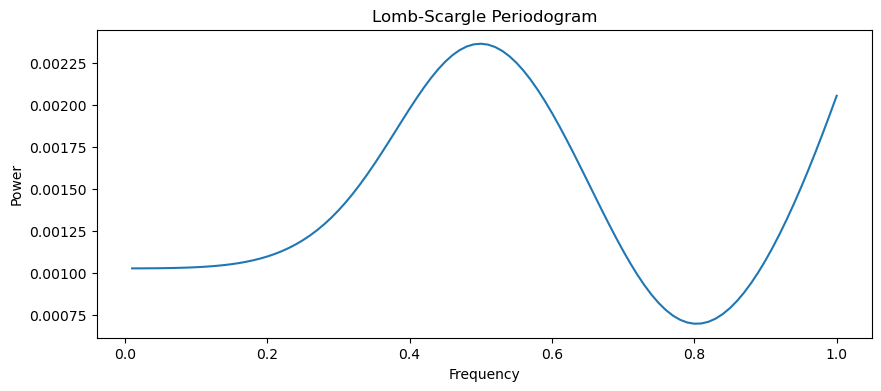

In [71]:
# Print the frequencies and powers
for f, p in zip(focus_freqs, focus_power):
    print(f"Frequency: {f}, Power: {p}")

# Or plot the periodogram
plt.figure(figsize=(10, 4))
plt.plot(focus_freqs, focus_power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()


In [72]:
freqs, power = compute_lomb_scargle(t, x, y)

In [73]:
peak_index = np.argmax(power)
peak_frequency = freqs[peak_index]
print(f"Peak Frequency: {peak_frequency}")

Peak Frequency: 2.79
